# 1. Collect and label image data

In [10]:
import os 
import time
import uuid     # To create nique uniform identifier for collected images
import cv2      # For access camera sensors for image data collection

## 1.1 Collect the image data

In [3]:
IMAGES_PATH = os.path.join('data','train','images')
number_images = 30

In the code block below, we will capture a number of images from the camera. There will be a little delay between each image capture for the user to make slight adjustment to their faces and postures.

In [15]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_EXPOSURE,-6)

for imgnum in range(number_images):
    print(f'Collecting image {imgnum}')
    
    ret, frame = cap.read()

    if not ret:
        print("There are some errors in the capture process")
        # break

    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('Frame', frame)
    time.sleep(1.0)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

## 1.2 Label the image data

In [ ]:
!labelme 

2025-02-12 17:58:49.556 | INFO     | labelme.config:get_config:66 - Loading config file from: C:\Users\mnguyen6\.labelmerc


# 2. Review Dataset and Build Image Loading Function 

## 2.1 Import TF and dependencies

In [18]:
import tensorflow as tf 
import json         # For parsing the json label files
import numpy as np
from matplotlib import pyplot as plt

## 2.2 Limit GPU Memory Growth

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(f'{len(gpus)} GPUs found')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

1 GPUs found


## 2.3 Load Image in to TF Data Pipeline

In [7]:
images = tf. data.Dataset.list_files('data\\train\\images\\*.jpg',shuffle=False)

In [8]:
images.take(1)

<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [9]:
images.as_numpy_iterator().next()

b'data\\train\\images\\28b03f66-e98b-11ef-8d00-4cd717a70326.jpg'

Helper function to load the images from the file path into an image generator object. This function first read the byte-encoded images and convert them to array of image pixel values.

This function is later [mapped]((https://www.tensorflow.org/versions/r2.10/api_docs/python/tf/data/Dataset?_gl=1*13bt2ru*_up*MQ..*_ga*MTI5NTI1MDM4LjE3Mzk0NzE0MjM.*_ga_W0YLR4190T*MTczOTQ3MTQyMy4xLjAuMTczOTQ3MTQ0Ni4wLjAuMA..#map)) on to the generator with the image path to load the images

In [10]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [11]:
images = images.map(load_image)

In [12]:
# Look at one image sample and its shape
print('Image pixel values \n',images.as_numpy_iterator().next())
print('\nImage shape ', images.as_numpy_iterator().next().shape)

Image pixel values 
 [[[242 249 241]
  [242 249 241]
  [242 250 239]
  ...
  [235 238 229]
  [237 238 230]
  [237 237 229]]

 [[241 248 240]
  [242 249 241]
  [242 250 239]
  ...
  [232 238 228]
  [235 236 228]
  [234 234 226]]

 [[238 248 239]
  [239 249 240]
  [240 250 241]
  ...
  [233 243 232]
  [238 241 234]
  [242 241 236]]

 ...

 [[231 248 240]
  [230 247 239]
  [228 245 239]
  ...
  [222 234 222]
  [219 230 216]
  [215 226 212]]

 [[228 247 241]
  [227 246 240]
  [225 244 238]
  ...
  [227 237 226]
  [222 233 219]
  [218 229 215]]

 [[227 246 240]
  [226 245 239]
  [225 244 238]
  ...
  [231 241 230]
  [227 238 224]
  [224 235 221]]]

Image shape  (480, 640, 3)


In [13]:
type(images)  # This is a tensorflow dataset object 

tensorflow.python.data.ops.dataset_ops.MapDataset

## 2.4 Display raw data with Matplotlib

Group the images in the generator into small batches of 4 images => [Data batching]((https://www.tensorflow.org/versions/r2.10/api_docs/python/tf/data/Dataset?_gl=1*13bt2ru*_up*MQ..*_ga*MTI5NTI1MDM4LjE3Mzk0NzE0MjM.*_ga_W0YLR4190T*MTczOTQ3MTQyMy4xLjAuMTczOTQ3MTQ0Ni4wLjAuMA..#map))

In [14]:
image_generator = images.batch(4).as_numpy_iterator()    # Batch the images into batches of 4

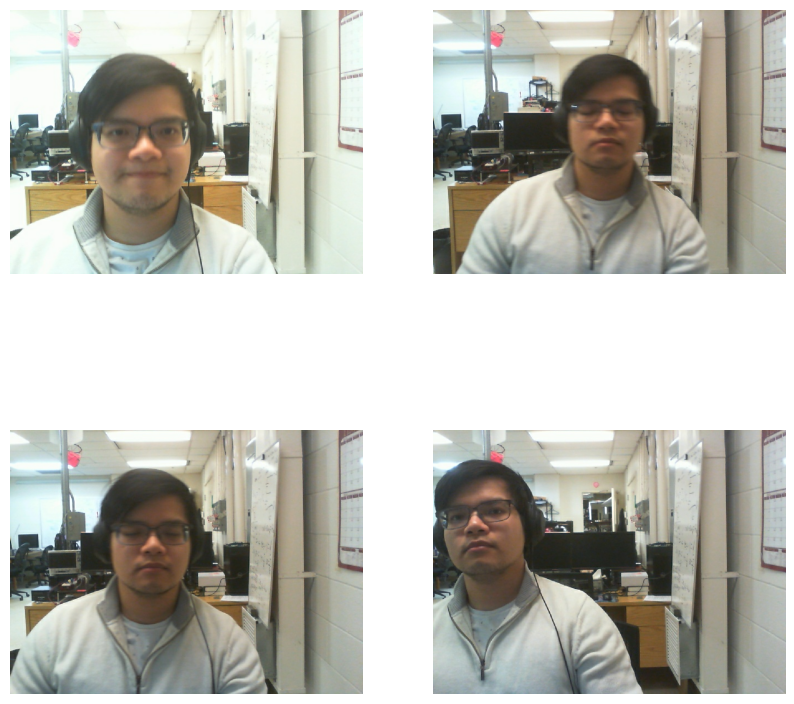

In [15]:
plot_images = image_generator.next()    # Get the next batch of images
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for idx, image in enumerate(plot_images):
    ax[idx%2, idx//2].imshow(image)
    ax[idx%2, idx//2].axis('off')

plt.show()

# 3. Partition Unaugmented Data

## 3.1 Moving the images into corresponding directories
The following functions are responsible for randomly splitting the image data according to the desired train/validation/test split

In [21]:
import random

def count_images(directories):
    """
    Function to count the number of images in a list of directories
    """
    return [len(tf.io.gfile.glob(os.path.join(directory, '*.jpg'))) for directory in directories]

def move_images(source_dir, target_dir, num_images):
    """
    Function to move images from one directory to another
    """
    images = tf.io.gfile.glob(os.path.join(source_dir, '*.jpg'))        # List of image paths in the source directory
    random.shuffle(images)
    for image_path in images[:num_images]:
        filename = os.path.basename(image_path)                         # Get the filename    
        target_path = os.path.join(target_dir, filename)                # Create the target path
        tf.io.gfile.copy(image_path, target_path, overwrite=True)       # Copy the image to the target path
        tf.io.gfile.remove(image_path)                                  # Remove the image from the source directory

def data_split(train_dir, val_dir, test_dir, desired_train=0.8, desired_val=0.2, seed=42):
    """
    Function to split the data (both images and labels) into training, validation, and possibly testing sets
    """
    # Calculate the proportion of images for training, validation, and testing
    total_proportion = desired_train + desired_val
    if total_proportion > 1:
        raise ValueError('The sum of desired_train and desired_val must not exceed 1')
    else:
        desired_test = 1 - total_proportion

    train_img_dir = os.path.join(train_dir, 'images')
    # Ensure the validation image directory exists
    val_img_dir = os.path.join(val_dir, 'images')
    os.makedirs(val_img_dir, exist_ok=True)
    # Ensure the test image directory exists (if provided)
    test_img_dir = os.path.join(test_dir, 'images')
    os.makedirs(test_img_dir, exist_ok=True)

    # Find the current number of images in train, val, and test
    train_count, val_count, test_count = count_images([train_img_dir,val_img_dir,test_img_dir])
    total_images = train_count + val_count + test_count

    # Find the desired number of images in train, val, and test
    desired_train_count = int(total_images * desired_train)
    desired_val_count = int(total_images * desired_val) if desired_test else total_images - desired_train_count
    desired_test_count = total_images - desired_train_count - desired_val_count if desired_test else 0
    
    # Moving images between validation and test directories, then recount the images
    if val_count > desired_val_count:
        move_images(val_img_dir, test_img_dir, val_count - desired_val_count)
    elif val_count < desired_val_count:
        move_images(test_img_dir, val_img_dir, desired_val_count - val_count)

    train_count, val_count, test_count = count_images([train_img_dir,val_img_dir,test_img_dir])

    # Moving the images between the training and test directories
    if test_count > desired_test_count:
        move_images(test_img_dir, train_img_dir, test_count - desired_test_count)
    elif test_count < desired_test_count:
        move_images(train_img_dir, test_img_dir, desired_test_count - test_count)

    # Find the current number of images in train, val, and test after the shift
    train_count, val_count, test_count = count_images([train_img_dir,val_img_dir,test_img_dir])

    return train_count, val_count, test_count

In [22]:
train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'

data_split(train_dir, val_dir, test_dir, 
           desired_train=0.8, 
           desired_val=0.1)

(26, 3, 4)

## 3.2 Move the corresponding labels

The code block below goes into each images directory in {train/test/val} and look at each jpg file. It then looks at the corresponding json file with the matching name in the data\\train\\labels directory and move them to the train/test/val images directory

1. Goes into each directory train, test, and val (the first for loop)
2. Goes into each jpg file in the images directory (the second for loop)
3. Replaces the .jpg extension with the .json extension for each filename. If there is an existing file path of the file in data\\train\\labels, replace that file path with one that resides in the corresponding labels folder

In [ ]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder,'images')):
        filename = file.split('.')[0]+'.json'                               # JSON file of the label
        existing_filepath = o s.path.join('data','train','labels',filename)

        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

# 4. Introduction to Albumentations for Image & Labels Augmentation 
This section is an introduction to using Albumentation to augment an image and the bounding boxes. We will only work with one test image for this section before moving on to performing augmentation with all images

## 4.1 Set up Albumentations


[Document for bounding box augmentation](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/)

In [62]:
import albumentations as alb

In [63]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.VerticalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2)],
                         bbox_params = alb.BboxParams(format='albumentations', label_fields=['class_labels']))

## 4.2 Load a Test Image and Annocation with OpenCV and JSON

In [64]:
image_test = cv2.imread(os.path.join('data','train','images','38cd7dfc-e98b-11ef-a4ed-4cd717a70326.jpg'))

with open(os.path.join('data','train','labels','38cd7dfc-e98b-11ef-a4ed-4cd717a70326.json'),'r') as f:
    label = json.load(f)            # Load the json file. The file is formatted as a dictionary

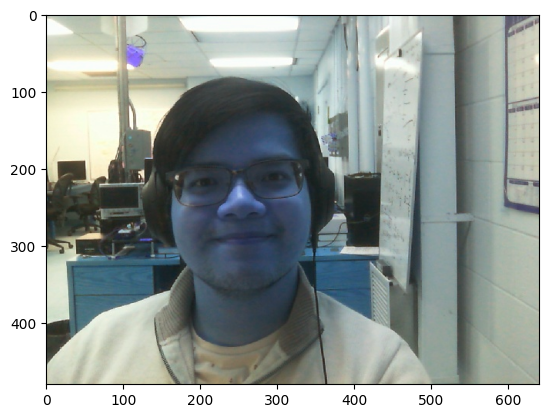

In [67]:
plt.imshow(image_test)

In [65]:
# Extract the bounding box coordinates and class labels from the json file
print('Detected label(s): ',label['shapes'][0]['label'])
print('Coordinates of the bounding box: ',label['shapes'][0]['points'])

Detected label(s):  face
Coordinates of the bounding box:  [[141.1711711711712, 117.02702702702705], [370.0, 364.77477477477476]]


## 4.3 Extract Coordinates and Rescale to Match Image Resolution

Using nested list comprehensions to flatten the coordinate values of the bounding box

In [66]:
coords = [val for sublist in label['shapes'][0]['points'] for val in sublist]
coords

[141.1711711711712, 117.02702702702705, 370.0, 364.77477477477476]

Normalize the bounding box coordinates to agree with albumentations bounding box format

In [53]:
coords_norm = list(np.divide(coords, [640,480,640,480]))
coords_norm

[0.22057995495495503, 0.24380630630630634, 0.578125, 0.7599474474474474]

In [60]:
image_augmented = augmentor(image=image_test, bboxes=[coords_norm], class_labels=['face'])
print(type(image_augmented))
print("The keys in the augmented image dictionary: ",image_augmented.keys())
print("The shape of the augmented image: ",image_augmented['image'].shape)
print("The coordinates of the bounding box in the augmented image: ",image_augmented['bboxes'])

<class 'dict'>
The keys in the augmented image dictionary:  dict_keys(['image', 'bboxes', 'class_labels'])
The shape of the augmented image:  (450, 450, 3)
The coordinates of the bounding box in the augmented image:  [[0.4244444444444444, 0.24894894493950737, 0.9329529571533203, 0.7994994693332248]]


We can visualize the verify whether the bounding is adjusted accordingly by drawing a rectangle on the augmented image

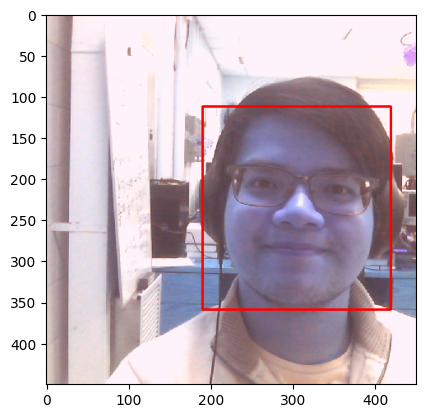

In [ ]:
cv2.rectangle(image_augmented['image'],
                # Rescaled the coordinates to the cropped image size
                tuple(np.multiply(image_augmented['bboxes'][0][:2], [450,450]).astype(int)),
                tuple(np.multiply(image_augmented['bboxes'][0][2:], [450,450]).astype(int)),
                (255,0,0), 2)

plt.imshow(image_augmented['image'])

# 5. Build and Run Augmentation Pipeline

## 5.1 Run Augmentation Pipeline

In [ ]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data',partition,'images')):
        img = cv2.imread(os.path.join('data',partition,'images',image))

        coords = [0, 0, 0.00001, 0.00001]
        label_path = os.path.join('data', partition 'labels', f'{image.split(".")[0]}.json')
        
        # There are some images without a label file (no face in the image)
        if os.path.exists(label_path)